# Model implementation and some tests

This notebook shows Python code implementing a model presented in a paper by Lagi et al. (2015) (doi: 10.1073/pnas.1413108112). The implementation according to the paper does not reproduce the results shown there. However, it is possible to modify the equations and parameter values somewhat, so that the model behaves as presented in the paper. Last, we show a few simple tests of how sensitive the model is to various changes.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5)
FIGSIZE = (9, 5)

## Load input data

We load monthly S&P500 and treasury bonds data as specified in the article. Here, we load it between January 2004 and January 2012. (Note that the treasury bonds data is transformed as 1/x, as specified in the paper.) We fetched the data from Yahoo Finance in the form of csv files. Loading the data is straightforward, but for brevity put in a separate file. See GitHub repository (https://github.com/rasmuse/food-prices-model) for futher details.

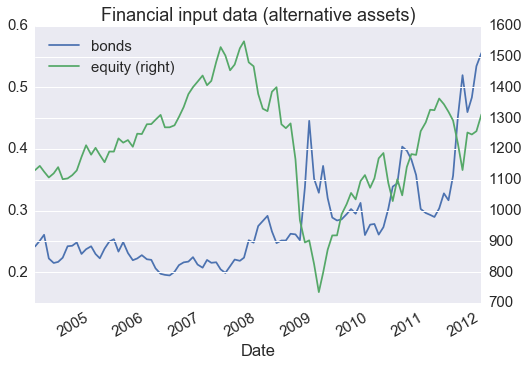

In [2]:
import data
start = pd.datetime(2004, 1, 1)
end = pd.datetime(2012, 1, 31)

P_assets = data.load_assets(start=start, end=end)
ax = P_assets.plot(y=['bonds', 'equity'], secondary_y=['equity'])
ax.set_title('Financial input data (alternative assets)');

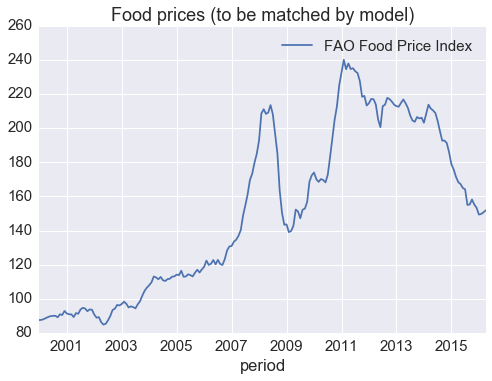

In [3]:
food_price_index = data.load_price_index()
ax = food_price_index.plot(label='FAO Food Price Index')
ax.legend()
ax.set_title('Food prices (to be matched by model)');

# Model implementation according to the paper

Here is an implementation of the model as specified in the paper. A more carefully commented version is available in the GitHub repository (https://github.com/rasmuse/food-prices-model).

In [4]:
def run_model(a, b, k_sp, k_sd, P_assets, k, speculation_start, t0=0):
    # Reindex asset prices
    calendar_times = P_assets.index
    integer_times = np.arange(t0, len(calendar_times)+t0)
    P_assets.index = integer_times

    integer_speculation_start = calendar_times.get_loc(speculation_start)

    P = pd.Series(index=integer_times)

    # Equilibrium prices for the first time steps
    for t in integer_times[:2]:
        P[t] = a + b * (t ** 2)
        
    for t in integer_times[1:-1]:
        k_c = (a + b * t ** 2) * k_sd + b * (2 * t  + 1) # Eqn. 28 in SI
        P[t+1] = k_c + (1 - k_sd) * P[t] # SI Eqn. 27 and 29

        if t >= integer_speculation_start:
            P[t+1] += k_sp * (P[t] - P[t-1]) # auto-speculation
            for asset_name in P_assets.columns:
                P_asset = P_assets[asset_name] # alternative assets
                P[t+1] += k[asset_name] * (P_asset[t] - P_asset[t-1])

    P.index = calendar_times
    P_assets.index = calendar_times

    return P

## Testing the implementation with parameters from the paper

In [5]:
# The parameters reported in the paper
reported_params = dict(
    a=113,
    k_sd=0.093,
    b=0.011,
    k_sp=1.27,
    k={'equity': -.085, 'bonds': -48.2},
    speculation_start=pd.datetime(2007, 6, 1),
    P_assets=P_assets)

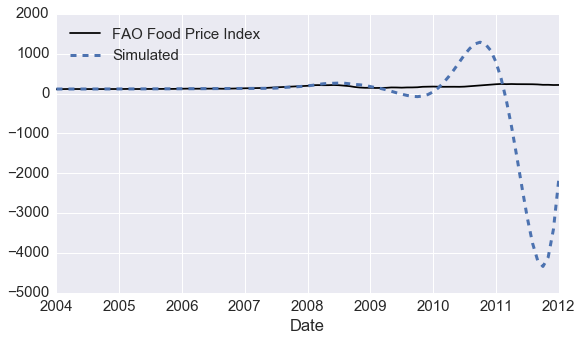

In [6]:
def plot_results(P, label='Simulated'):
    ax = food_price_index.plot(label='FAO Food Price Index', color='k')
    P.plot(ax=ax, label=label, ls='--', lw=3, figsize=FIGSIZE)
    ax.legend(loc='best')
    ax.set_xlim(P.index.min(), P.index.max())
    
P = run_model(**reported_params)

plot_results(P)

As seen in the plot above, the implementation described in the paper does not work. Why? Two corrections are needed:

1. Change the equation for two time steps just when the speculation is turned on.
2. Specify the parameters with additional decimals.

# Corrected model implementation

The following implementation is very similar to the above one. The only change is the addition of a `magic_price` parameter. If `magic_price` is specified, it changes the model equation for two time steps.

In [7]:
def run_model(a, b, k_sp, k_sd, P_assets, k, speculation_start, t0=0, magic_price=None):
    # Reindex asset prices
    calendar_times = P_assets.index
    integer_times = np.arange(t0, len(calendar_times)+t0)
    P_assets.index = integer_times

    integer_speculation_start = calendar_times.get_loc(speculation_start)

    P = pd.Series(index=integer_times)

    # Equilibrium prices for the first time steps
    for t in integer_times[:2]:
        P[t] = a + b * (t ** 2)
        
    for t in integer_times[1:-1]:
        k_c = (a + b * t ** 2) * k_sd + b * (2 * t  + 1) # Eqn. 28 in SI
        P[t+1] = k_c + (1 - k_sd) * P[t] # SI Eqn. 27 and 29

        if t >= integer_speculation_start:

            # THIS IS THE CHANGE
            if magic_price is not None:
                P[integer_speculation_start] = magic_price
            
            P[t+1] += k_sp * (P[t] - P[t-1]) # auto-speculation
            for asset_name in P_assets.columns:
                P_asset = P_assets[asset_name] # alternative assets
                P[t+1] += k[asset_name] * (P_asset[t] - P_asset[t-1])

    P.index = calendar_times
    P_assets.index = calendar_times

    return P

## A run with corrected model and corrected parameters

We now make two changes to the parameters:

1. We specify the `magic_price=140.45`.
2. We specify some other parameters with higher precision.

In [8]:
# The corrected parameters (reproducing the paper results)
corrected_params = reported_params.copy()
corrected_params.update(
    k_sd=0.09256,
    k_sp=1.2725,
    k={'equity': -0.085033, 'bonds': -48.2},
    magic_price=140.45)

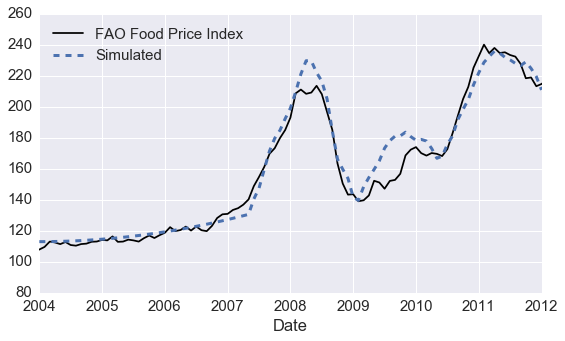

In [9]:
P = run_model(**corrected_params)
plot_results(P)

# Predictions further in the future?

The paper claims as a strength of the model that it successfully reproduces the food price changes until January 2012 even if parameters are only fitted until March 2011. Similarly, the parameters fit until January 2012 could then be expected to match the development further into the future. Here is a test.

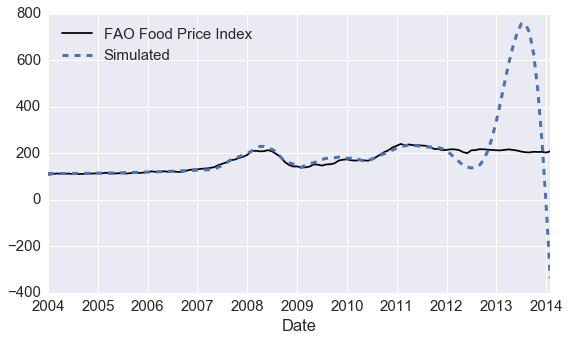

In [10]:
start = pd.datetime(2004, 1, 1)
end = pd.datetime(2014, 2, 28)
P_assets_longer_time = data.load_assets(start=start, end=end)
corrected_params_longer_time =  corrected_params.copy()
corrected_params_longer_time.update(P_assets=P_assets_longer_time)

P = run_model(**corrected_params_longer_time)
plot_results(P)

# Sensitivity

How sensitive is this model to

* changes in parameter values?
* presence of the added `magic_price` logic?
* noise (e.g., added to the equilibrium price)?

To illustrate, we show a few different tests.

## Test 1. Paper parameters, but with `magic_price`

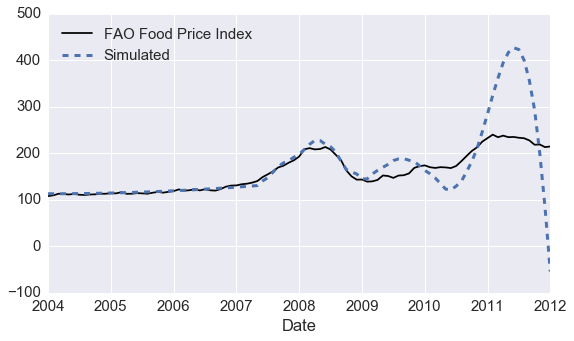

In [11]:
magic_price_only = reported_params.copy()
magic_price_only.update(magic_price=140.45)
P = run_model(**magic_price_only)
plot_results(P)

## Test 2. Corrected parameters, but without `magic_price`

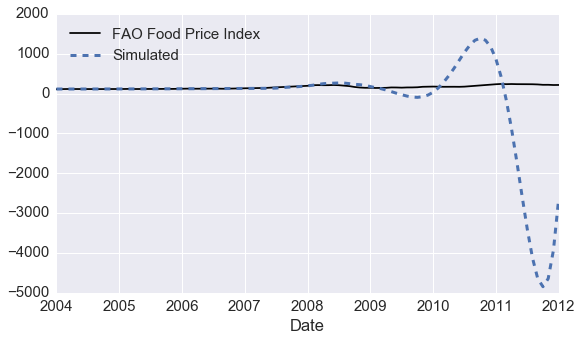

In [12]:
corrected_without_magic = corrected_params.copy()
corrected_without_magic.update(magic_price=None)
P = run_model(**corrected_without_magic)
plot_results(P)

## Test 3. Adding noise to the equilibrium price

We disturb the equilibrium price with 1% white noise. by multiplying each k_c(t) value with a random, iid number in the interval [0.99, 1.01]. This requires a small change to the model implementation:

In [13]:
def run_model(a, b, k_sp, k_sd, P_assets, k, speculation_start, t0=0,
              magic_price=None, noise_level=0):
    # Reindex asset prices
    calendar_times = P_assets.index
    integer_times = np.arange(t0, len(calendar_times)+t0)
    P_assets.index = integer_times

    integer_speculation_start = calendar_times.get_loc(speculation_start)
    
    noise = pd.Series(
        data=(2 * (np.random.rand(len(integer_times)) - .5) * noise_level),
        index=integer_times)

    P = pd.Series(index=integer_times)

    # Equilibrium prices for the first time steps
    for t in integer_times[:2]:
        P[t] = a + b * (t ** 2)
        
    for t in integer_times[1:-1]:
        k_c = (a + b * t ** 2) * k_sd + b * (2 * t  + 1) # Eqn. 28 in SI
        k_c *= (1 + noise[t])
        P[t+1] = k_c + (1 - k_sd) * P[t] # SI Eqn. 27 and 29

        if t >= integer_speculation_start:
            if magic_price is not None:
                P[integer_speculation_start] = magic_price
            
            P[t+1] += k_sp * (P[t] - P[t-1]) # auto-speculation
            for asset_name in P_assets.columns:
                P_asset = P_assets[asset_name] # alternative assets
                P[t+1] += k[asset_name] * (P_asset[t] - P_asset[t-1])

    P.index = calendar_times
    P_assets.index = calendar_times

    return P

Because the noise is random, each simulation comes out differently. To illustrate the range of possible effects, we make a few independent noisy simulations.

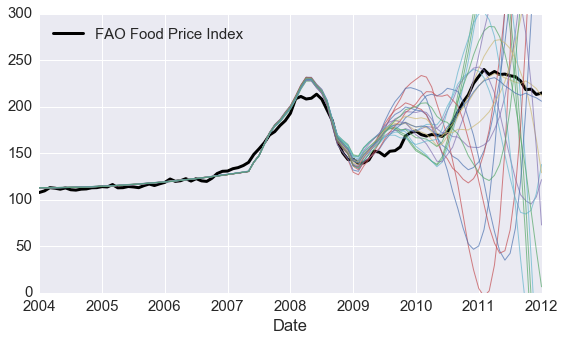

In [14]:
noisy_params = corrected_params.copy()
noisy_params.update(noise_level=0.01)

num_simulations = 20
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

ax = food_price_index.plot(label='FAO Food Price Index', color='k', lw=3)
ax.legend(title='')
for i in range(num_simulations):
    P = run_model(**noisy_params)
    P.plot(ax=ax, ls='-', lw=1, alpha=0.7)
ax.set_xlim(P.index.min(), P.index.max())
ax.set_ylim(0, 300);